# Generación de Gráficas de estudio de viabilidad de la ejecución de `CreditRiskAnalysis`

*Autor:* Manuel Soto Jiménez
    
*Tutores:* Francisco Javier Gómez Arribas y Luis de Pedro Sánchez
    
*Mayo de 2021*

In [2]:
from CreditRiskAnalysis import CreditRiskAnalysis

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

plt.style.use("seaborn")

## Obtención del *backend* sobre el que analizar propiedades

In [3]:
# En False si queremos ejecutar en un backend de IBMQ (ojo al número de qubits)
simulation = True

if simulation:
    #backend = Aer.get_backend('statevector_simulator')
    backend = Aer.get_backend('qasm_simulator')
else:
    # A partir de 3 assets del portfolio en pocos backends se podrá ejecutar todo
    Backend_qubits = 9
    # Sustituir la api_token por la del usuario
    api_token = '586c9c6ab7bc96f00053b32e6600cf6c59e10280063dbcfb6f643a427b7cb17934085b935632ffc325f11c14522476bc11bf7879d5cc0b71c1bfd0a40ad9ee0c'
    IBMQ.save_account(api_token)
    provider = IBMQ.load_account()

    backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= Backend_qubits and
                                           not b.configuration().simulator and b.status().operational==True))
print('Given IBMQ backend: '+backend.name())

Given IBMQ backend: qasm_simulator


### Ejemplo de ejecución de la clase `CreditRiskAnalysis`

In [4]:
# Datos del portfolio a analizar
p_zeros = [0.15, 0.2,0.3]
rhos = [0.1, 0.05,0.15]
lgd = [2,1,6]

------------ RESULTS OF U IN "qasm_simulator" ------------
Expected Loss E[L]:                        2.25195312
Value at Risk VaR[L]:                      8.00000000
P[L <= VaR[L]]:                            0.98828125
Conditional Value at Risk CVaR[L]:         9.00000000


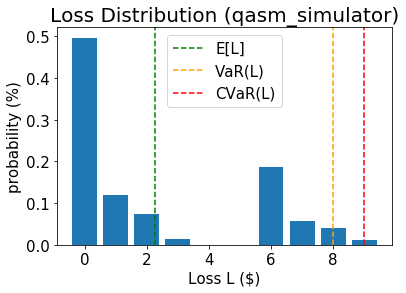

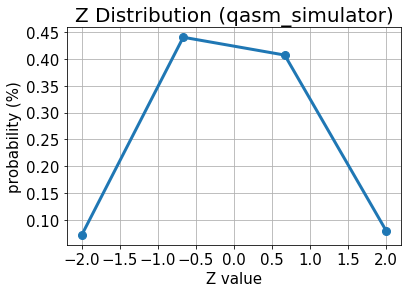

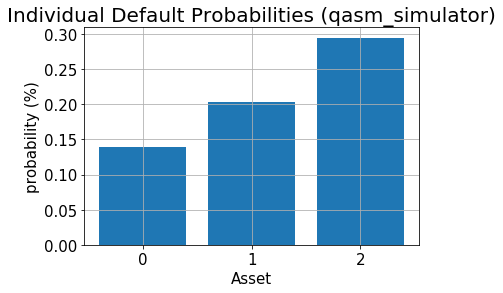


----- RESULTS OF iQAE FOR E IN "qasm_simulator" -----
Exact value:    		2.25195312
Estimated value:		2.14446898
Confidence interval: 		[1.95207068, 2.33686728]


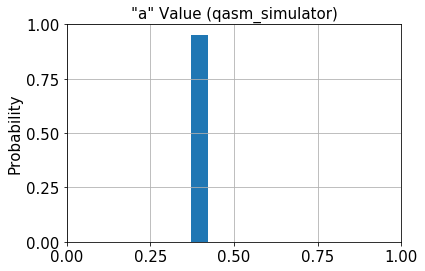

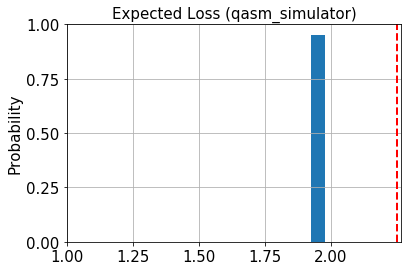


--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         4       0.705     9            1.000
 4           0.705         6       0.896     9            1.000
 6           0.896         8       0.987     9            1.000
 6           0.896         7       0.948     8            0.987
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------

----- RESULTS OF iQAE FOR VaR IN "qasm_simulator" -----
Estimated Value at Risk:  8
Exact Value at Risk:      8
Estimated Probability:    0.98668354
Exact Probability:        0.98828125

----- RESULTS OF iQAE FOR CVaR IN "qasm_simulator" -----
Exact CVaR: 

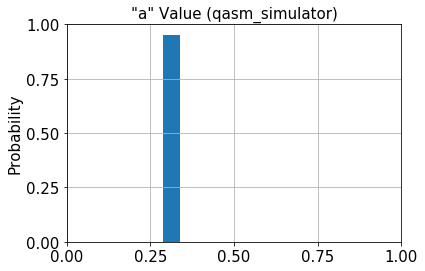

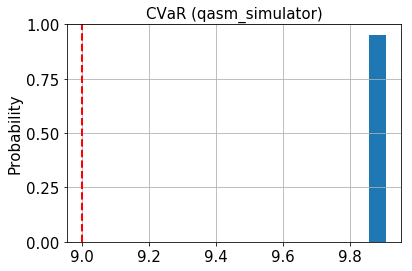

In [5]:
cra = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend)
cra.run_all()

# Evolución de los resultados en función del número de *assets*

In [6]:
p_zeros = [0.15]
rhos = [0.1]
lgd = [1]

new_pzero = 0.1
new_rho = 0.05
new_lgd = 1

n_iters = 8

## Modelo de incertidumbre ($U$)

In [ ]:
l_num_qubits = []
l_losses = []
l_exp = []
l_var = []
l_cvar = []
l_pdf = []
l_p_z = []
l_p_default = []

for i in range(n_iters):
    p_zeros += [new_pzero]
    rhos += [new_rho]
    lgd += [new_lgd]
    
    cra_i = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend)
    
    print("Running CGI for iteration "+str(i)+"...")
    
    num_qubits, losses, expected_loss, exact_var, exact_cvar, pdf, p_z, p_default = cra_i.compute_U()
    l_num_qubits.append(num_qubits)
    l_losses.append(losses)
    l_exp.append(expected_loss)
    l_var.append(exact_var)
    l_cvar.append(exact_cvar)
    l_pdf.append(pdf)
    l_p_z.append(p_z)
    l_p_default.append(p_default)
    
    cra_i.graph_U()

print("Done!")
    
graph_result = {}
graph_result["n_qubits"] = l_num_qubits
graph_result["losses"] = l_losses
graph_result["exp"] = l_exp
graph_result["var"] = l_var
graph_result["cvar"] = l_cvar
graph_result["pdf"] = l_pdf
graph_result["p_z"] = l_p_z
graph_result["p_default"] = l_p_default

pickle.dump( graph_result, open("graph_data/U-assets_2.p", "wb" ))

### Número de qubits necesarios

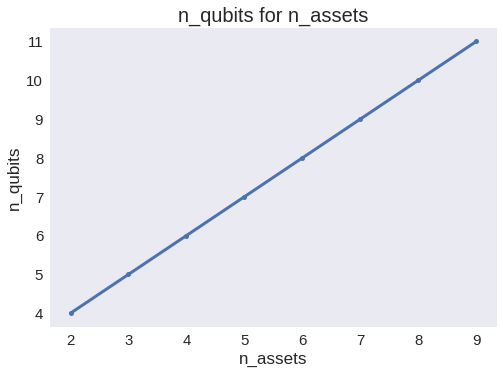

In [10]:
n_assets_values = range(2,n_iters+2)
n_qubits = graph_result["n_qubits"]
plt.plot(n_assets_values, n_qubits, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('n_assets', size=17)
plt.ylabel('n_qubits', size=17)
plt.title('n_qubits for n_assets', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("graph_img/U_n_qubits.png")
plt.show()

## Evolución de la estimación cuántica de E (con y sin iQAE)

In [ ]:
p_zeros = [0.15]
rhos = [0.1]
lgd = [1]

l_exp = []
l_result = []
l_n_qubits = []

for i in range(n_iters):
    p_zeros += [new_pzero]
    rhos += [new_rho]
    lgd += [new_lgd]
    
    cra_i = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend,epsilon=0.05)
    
    print("Running CGI for iteration "+str(i)+"...")
    
    expected_loss, iqae_result, n_qubits = cra_i.print_qae_E()

    l_exp.append(expected_loss)
    l_result.append(iqae_result)
    l_n_qubits.append(n_qubits)

print("Done!")

graph_result = {}

graph_result["exp"] = l_exp
graph_result["result"] = l_result
graph_result["n_qubits"] = l_n_qubits

pickle.dump( graph_result, open("graph_data/E-assets_1.p", "wb" ))

### Número de qubits necesarios

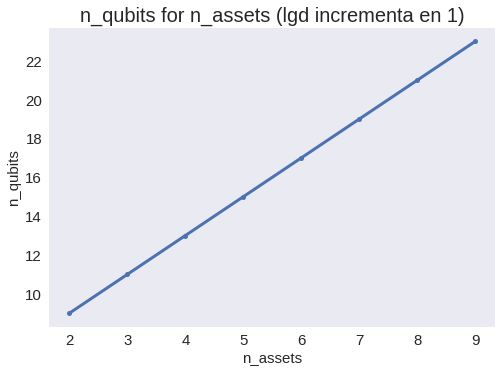

In [11]:
n_assets_values = range(2,n_iters+2)
n_qubits = graph_result["n_qubits"]
plt.plot(n_assets_values, n_qubits, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('n_assets', size=15)
plt.ylabel('n_qubits', size=15)
plt.title('n_qubits for n_assets (lgd incrementa en '+str(new_lgd)+')', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("graph_img/E_n_qubits.png")
plt.show()

### Numero de qubits necesarios según $\lambda'$

In [ ]:
d_num_qubits = {}
lgds = [1,2,4,8,16]


for new_lgd in lgds:
    d_num_qubits[new_lgd] = []
    p_zeros=[new_pzero]
    rhos=[new_rho]
    lgd = [new_lgd]
    for i in range(n_iters):
        p_zeros += [new_pzero]
        rhos += [new_rho]
        lgd += [new_lgd]

        cra_i = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend)

        print(str(new_lgd)+": Running CGI for iteration "+str(i)+"...")

        expected_loss, iqae_result, n_qubits = cra_i.print_qae_E()

        d_num_qubits[new_lgd].append(n_qubits)

print(d_num_qubits)
print("Done!")

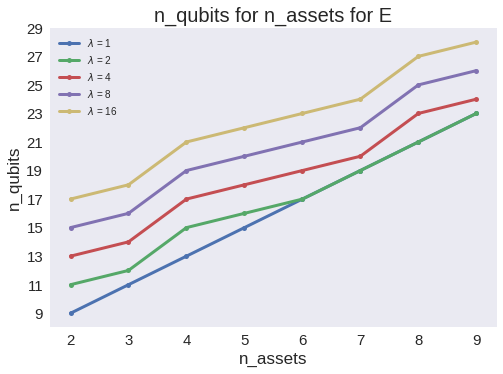

In [22]:
n_assets_values = range(2,n_iters+2)
for new_lgd in lgds:
    n_qubits = d_num_qubits[new_lgd]
    plt.plot(n_assets_values, n_qubits, 'o-', linewidth=3, markersize=5,label="$\lambda$ = "+str(new_lgd))
plt.xlabel('n_assets', size=17)
plt.ylabel('n_qubits', size=17)
plt.title('n_qubits for n_assets for E', size=20)
plt.grid()
plt.xticks(size=15)
plt.yticks(range(9,30,2),size=15)
plt.legend()
plt.savefig("graph_img/E_n_qubits_2.png")
plt.show()

### Error cometido en la estimación ($|E_{exacta}-E_{iqae}|$)

In [ ]:
exact_values = graph_result["exp"]
estimated_values = graph_result["result"]
error = np.absolute(np.array(exact_values) - np.array(estimated_values))

plt.plot(n_assets_values, error, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('n_assets', size=17)
plt.ylabel('error', size=17)
plt.title('Error cometido (lgd incrementa en '+str(new_lgd)+')', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("graph_img/E_error.png")
plt.show()

## Evolución de la estimación cuántica (iQAE) de CDF en función del epsilon dado

In [34]:
l_qae_results = []
#l_epsilon = np.linspace(0.01,0.2,15)
l_epsilon = np.logspace(-2,-0.4,15)
l_sizes = []

# Datos del portfolio a analizar
p_zeros = [0.15, 0.2,0.3]
rhos = [0.1, 0.05,0.15]
lgd = [2,1,6]

x_eval = 7

backend = Aer.get_backend('qasm_simulator')

for eps in l_epsilon:
    cra = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend,epsilon=eps)
    cra.run_qae_cdf(x_eval)
    l_qae_results.append(cra.qae_result)
    l_sizes.append(cra.get_qae_size())
    
graph_result = {}
graph_result["qae_results"] = l_qae_results
graph_result["epsilons"] = l_epsilon
graph_result["exact_result"] = cra.cdf[x_eval]
graph_result["sizes"] = l_sizes

pickle.dump( graph_result, open("graph_data/CDF-epsilon_3.p", "wb" ))

### Evolución de Potencias del Oráculo según epsilon

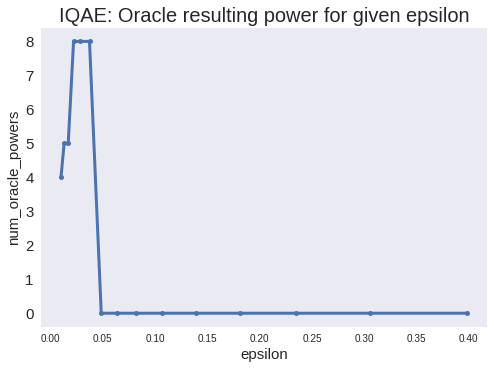

In [36]:
oracle_queries = [ result["powers"][-1] for result in graph_result["qae_results"] ]
epsilons = graph_result["epsilons"]

plt.plot(epsilons, oracle_queries, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('epsilon', size=15)
plt.ylabel('num_oracle_powers', size=15)
plt.title('IQAE: Oracle resulting power for given epsilon', size=20)
plt.xticks(size=10)
plt.yticks(size=15)
plt.savefig("graph_img/iqae_epsilon_potencias.png")
plt.show()

### Evolución del intervalo de confianza según epsilon

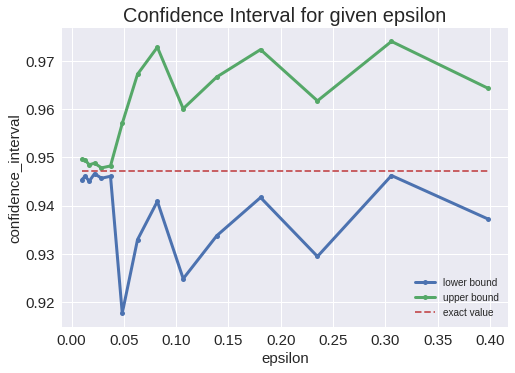

In [37]:
interval_l = [ result["confidence_interval"][0] for result in graph_result["qae_results"]]
interval_u = [ result["confidence_interval"][1] for result in graph_result["qae_results"]]

plt.plot(epsilons, interval_l, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('epsilon', size=15)
plt.ylabel('confidence_interval', size=15)
plt.title('Confidence Interval for given epsilon', size=20)
plt.xticks(size=15)
plt.yticks(size=15)


plt.plot(epsilons, interval_u, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('epsilon', size=15)
plt.ylabel('confidence_interval', size=15)
plt.title('Confidence Interval for given epsilon', size=20)
plt.xticks(size=15)
plt.yticks(size=15)

plt.plot(epsilons,len(epsilons)*[graph_result["exact_result"]],'--')

plt.legend(["lower bound", "upper bound","exact value"])
plt.savefig("graph_img/iqae_epsilon_ic.png")
plt.show()

### Epsilon resultante frente al pedido

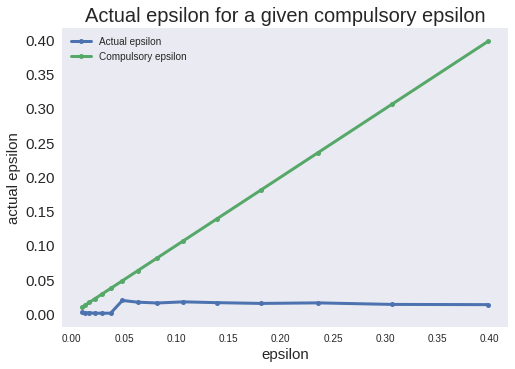

In [38]:
actual_epsilons = [ result["actual_epsilon"] for result in graph_result["qae_results"] ]
epsilons = graph_result["epsilons"]

plt.plot(epsilons, actual_epsilons, 'o-', linewidth=3, markersize=5)
plt.plot(epsilons, epsilons, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('epsilon', size=15)
plt.ylabel('actual epsilon', size=15)
plt.title('Actual epsilon for a given compulsory epsilon', size=20)
plt.xticks(size=10)
plt.yticks(size=15)

plt.legend(["Actual epsilon","Compulsory epsilon"])
plt.savefig("graph_img/iqae_epsilon_resultante.png")
plt.show()

### Profundidad del circuito en función de epsilon

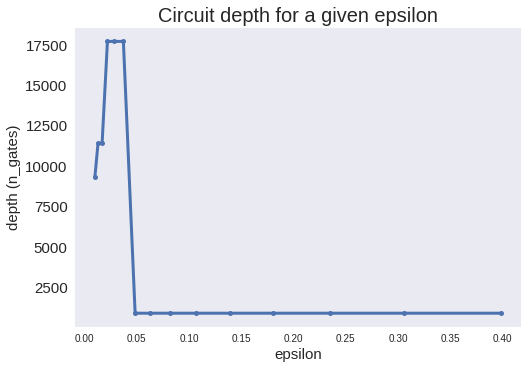

In [39]:
sizes = [ result["depth"] for result in graph_result["sizes"] ]
epsilons = graph_result["epsilons"]

plt.plot(epsilons, sizes, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('epsilon', size=15)
plt.ylabel('depth (n_gates)', size=15)
plt.title('Circuit depth for a given epsilon', size=20)
plt.xticks(size=10)
plt.yticks(size=15)
plt.savefig("graph_img/iqae_epsilon_depth.png")
plt.show()

## Evolución de la estimación cuántica (iQAE) de CDF en función del alpha dado

In [ ]:
l_qae_results = []
l_alpha = np.linspace(0.01,0.5,50)
l_sizes = []

# Datos del portfolio a analizar
p_zeros = [0.15, 0.2,0.3]
rhos = [0.1, 0.05,0.15]
lgd = [2,1,6]

x_eval = 7

backend = Aer.get_backend('qasm_simulator')

for alpha in l_alpha:
    cra = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend,alpha=alpha)
    cra.run_qae_cdf(x_eval)
    l_qae_results.append(cra.qae_result)
    l_sizes.append(cra.get_qae_size())
    
graph_result = {}
graph_result["qae_results"] = l_qae_results
graph_result["alpha"] = l_alpha
graph_result["exact_result"] = cra.cdf[x_eval]
graph_result["sizes"] = l_sizes

pickle.dump( graph_result, open("graph_data/CDF-alpha_3.p", "wb" ))

### Evolución de Potencias del Oráculo según alpha

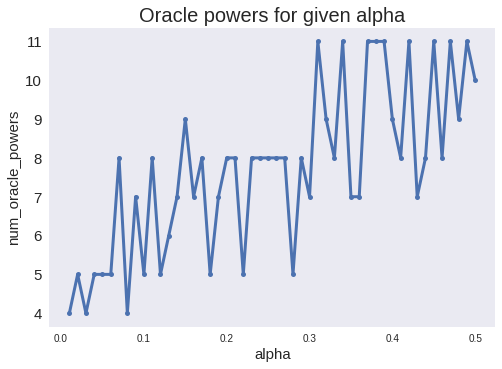

In [41]:
oracle_queries = [ result["powers"][-1] for result in graph_result["qae_results"] ]

plt.plot(l_alpha, oracle_queries, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('alpha', size=15)
plt.ylabel('num_oracle_powers', size=15)
plt.title('Oracle powers for given alpha', size=20)
plt.xticks(size=10)
plt.yticks(size=15)
plt.savefig("graph_img/iqae_alpha_potencias.png")
plt.show()

### Evolución del intervalo de confianza según alpha

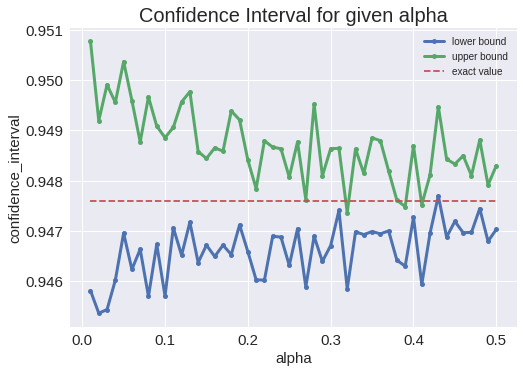

In [43]:
interval_l = [ result["confidence_interval"][0] for result in graph_result["qae_results"]]
interval_u = [ result["confidence_interval"][1] for result in graph_result["qae_results"]]

plt.plot(l_alpha, interval_l, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('alpha', size=15)
plt.ylabel('confidence_interval', size=15)
plt.title('Confidence Interval for given alpha', size=20)
plt.xticks(size=15)
plt.yticks(size=15)


plt.plot(l_alpha, interval_u, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xticks(size=15)
plt.yticks(size=15)

plt.plot(l_alpha,len(l_alpha)*[graph_result["exact_result"]],'--')

plt.legend(["lower bound", "upper bound","exact value"])
plt.savefig("graph_img/iqae_alpha_ci.png")
plt.show()

### Error resultante frente al alpha pedido

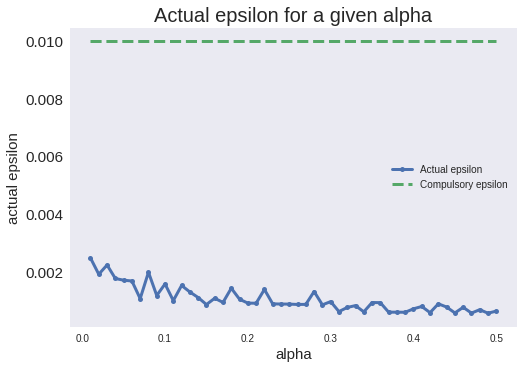

In [45]:
actual_epsilons = [ result["actual_epsilon"] for result in graph_result["qae_results"] ]

plt.plot(l_alpha, actual_epsilons, 'o-', linewidth=3, markersize=5)
plt.plot(l_alpha, [0.01] * len(l_alpha), '--', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('alpha', size=15)
plt.ylabel('actual epsilon', size=15)
plt.title('Actual epsilon for a given alpha', size=20)
plt.xticks(size=10)
plt.yticks(size=15)

plt.legend(["Actual epsilon","Compulsory epsilon"])
plt.savefig("graph_img/iqae_alpha_epsilon.png")
plt.show()

### Profundidad del circuito frente al alpha pedido

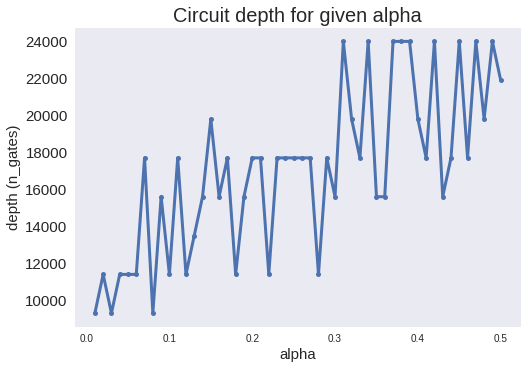

In [46]:
sizes = [ result["depth"] for result in graph_result["sizes"] ]

plt.plot(l_alpha, sizes, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('alpha', size=15)
plt.ylabel('depth (n_gates)', size=15)
plt.title('Circuit depth for given alpha', size=20)
plt.xticks(size=10)
plt.yticks(size=15)
plt.savefig("graph_img/iqae_epsilon_depth.png")
plt.show()

## Evolución de la profundidad de los circuitos en función del número de *assets*

In [4]:
p_zeros = [0.15]
rhos = [0.1]
lgd = [2]

new_pzero = 0.1
new_rho = 0.05
new_lgd = 1

n_iters = 8

backend = Aer.get_backend('qasm_simulator')

### Modelo de incertidumbre ($U$)

In [ ]:
l_sizes = []

for i in range(n_iters):
    p_zeros += [new_pzero]
    rhos += [new_rho]
    lgd += [new_lgd]
   
    cra_i = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend,ae_algorithm='ae')
    
    print("Running CGI for iteration "+str(i)+"...")
    
    cra_i.compute_U()
    l_sizes.append(cra_i.get_asm_size())

print("Done!")
    
graph_result_qae = {}
graph_result_qae["sizes"] = l_sizes

l_sizes = []

p_zeros = [0.15]
rhos = [0.1]
lgd = [2]

for i in range(n_iters):
    p_zeros += [new_pzero]
    rhos += [new_rho]
    lgd += [new_lgd]
   
    cra_i = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend)
    
    print("Running CGI for iteration "+str(i)+"...")
    
    cra_i.compute_U()
    l_sizes.append(cra_i.get_asm_size())

print("Done!")
    
graph_result_iqae = {}
graph_result_iqae["sizes"] = l_sizes

l_sizes = []

p_zeros = [0.15]
rhos = [0.1]
lgd = [2]

for i in range(n_iters):
    p_zeros += [new_pzero]
    rhos += [new_rho]
    lgd += [new_lgd]
   
    cra_i = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend,ae_algorithm='mlae')
    
    print("Running CGI for iteration "+str(i)+"...")
    
    cra_i.compute_U()
    l_sizes.append(cra_i.get_asm_size())

print("Done!")
    
graph_result_mlae = {}
graph_result_mlae["sizes"] = l_sizes


#pickle.dump( graph_result, open("graph_data/U-assets_4.p", "wb" ))

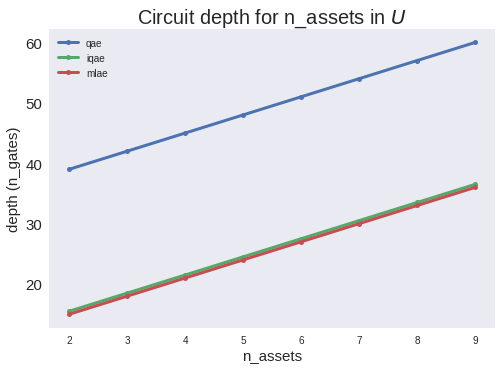

In [12]:
n_assets = [1 + i for i in range(1,n_iters+1)]
sizes_qae = [ result["depth"] for result in graph_result_qae["sizes"] ]
sizes_iqae = [ result["depth"]+0.5 for result in graph_result_iqae["sizes"] ]
sizes_mlae = [ result["depth"] for result in graph_result_mlae["sizes"] ]

plt.plot(n_assets, sizes_qae, 'o-', linewidth=3, markersize=5,label='qae')
plt.plot(n_assets, sizes_iqae, 'o-', linewidth=3, markersize=5,label='iqae')
plt.plot(n_assets, sizes_mlae, 'o-', linewidth=3, markersize=5,label='mlae')
plt.grid()
plt.legend()
plt.xlabel('n_assets', size=15)
plt.ylabel('depth (n_gates)', size=15)
plt.title('Circuit depth for n_assets in $U$', size=20)
plt.xticks(size=10)
plt.yticks(size=15)
plt.savefig("graph_img/depth_n_assets_U.png")
plt.show()

### QAE para la pérdida esperada ($E$)

In [23]:
p_zeros = [0.15]
rhos = [0.1]
lgd = [2]

new_pzero = 0.1
new_rho = 0.05
new_lgd = 1

n_iters = 8

In [ ]:
l_sizes = []

for i in range(n_iters):
    p_zeros += [new_pzero]
    rhos += [new_rho]
    lgd += [new_lgd]
    
    cra_i = CreditRiskAnalysis(p_zeros,rhos,lgd,backend=backend)
    
    print("Running CGI for iteration "+str(i)+"...")
    
    cra_i.print_qae_E()

    l_sizes.append(cra_i.get_qae_size())
    
print("Done!")

graph_result = {}

graph_result["sizes"] = l_sizes

pickle.dump( graph_result, open("graph_data/E-assets_3.p", "wb" ))

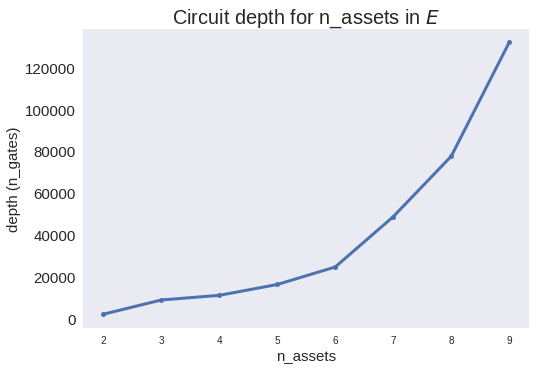

In [55]:
n_assets = [1 + i for i in range(1,n_iters+1)]
sizes = [ result["depth"] for result in graph_result["sizes"] ]

plt.plot(n_assets, sizes, 'o-', linewidth=3, markersize=5)
plt.grid()
plt.xlabel('n_assets', size=15)
plt.ylabel('depth (n_gates)', size=15)
plt.title('Circuit depth for n_assets in $E$', size=20)
plt.xticks(size=10)
plt.yticks(size=15)
plt.savefig("graph_img/depth_n_assets_E.png")
plt.show()